In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage import generic_filter, median
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, remove_small_objects, skeletonize, medial_axis, thin

In [2]:
image_path = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/train/images/21_training.tif'
mask_path = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/train/mask/21_training_mask.gif'
label_path = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/train/1st_manual/21_manual1.gif'
responses = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/visualization/drive_train_naive.npy')
radiis = np.load('/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/visualization/drive_rad_train_naive.npy')

In [3]:
image, mask, label = Image.open(image_path), Image.open(mask_path), Image.open(label_path)
image = -np.asarray(image)[..., 1] / 255.0          # green channel
label = np.asarray(label) / 255.0
mask = np.asarray(mask) > 0.5
rads = radiis[0]

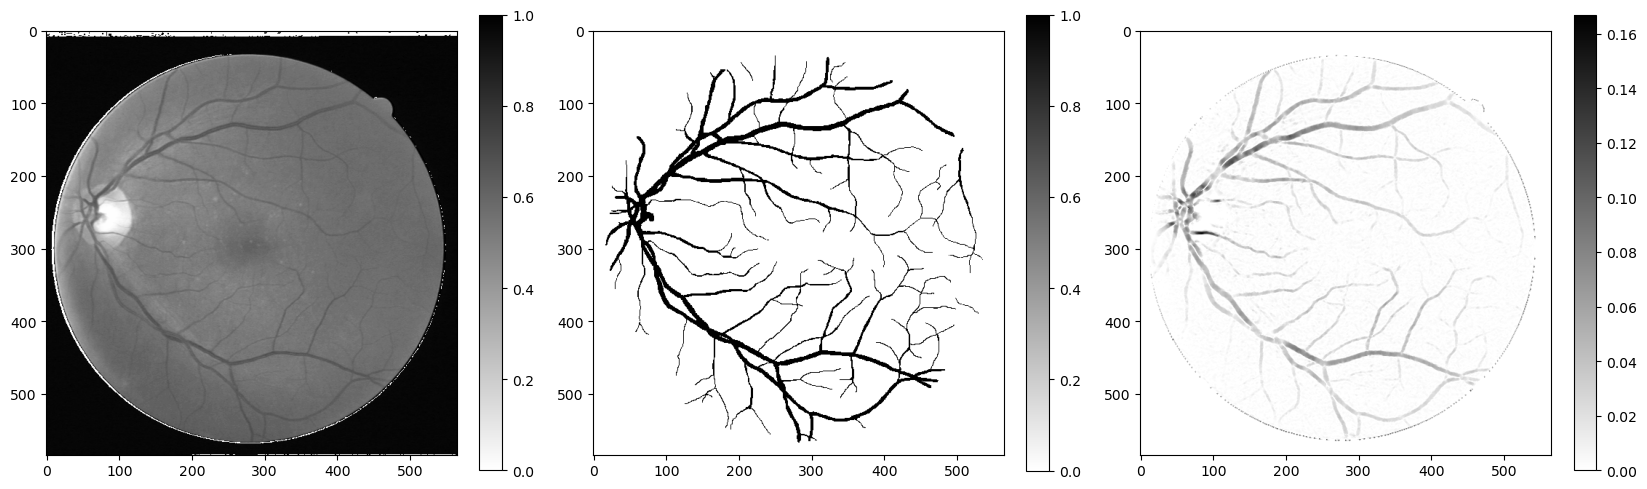

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
im1 = ax1.imshow(image, cmap='gray_r')
fig.colorbar(im1, ax=ax1, fraction=0.05)
im2 = ax2.imshow(label, cmap='gray_r')
fig.colorbar(im2, ax=ax2, fraction=0.05)
im3 = ax3.imshow(responses[0], cmap='gray_r')
fig.colorbar(im3, ax=ax3, fraction=0.05)

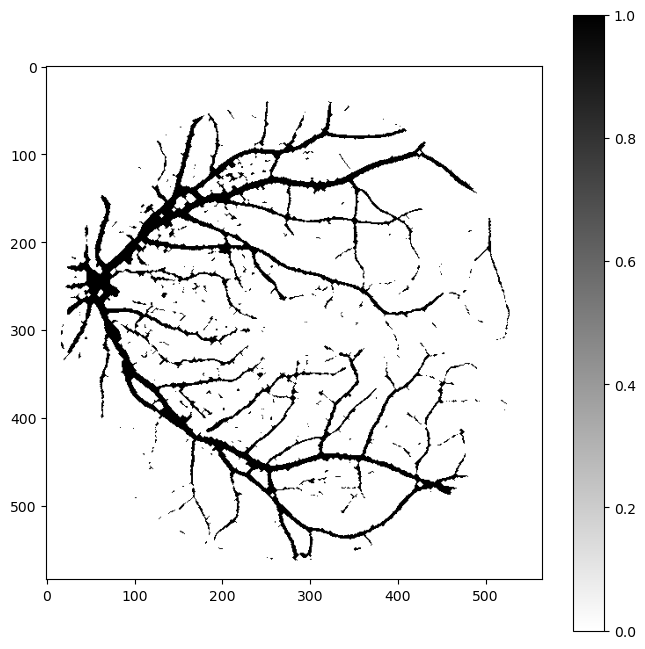

In [5]:
mask_erode = binary_erosion(mask, footprint=np.ones((7, 7)))
response = np.multiply(responses[0], mask_erode)

# binarize the response
threshold = 0.0045
bin_res = binary_closing(response > threshold)
bin_res = remove_small_objects(bin_res, min_size=15)
bin_res = binary_erosion(bin_res)
fig = plt.figure(figsize=(8, 8))
plt.imshow(bin_res, cmap='gray_r')
plt.colorbar()

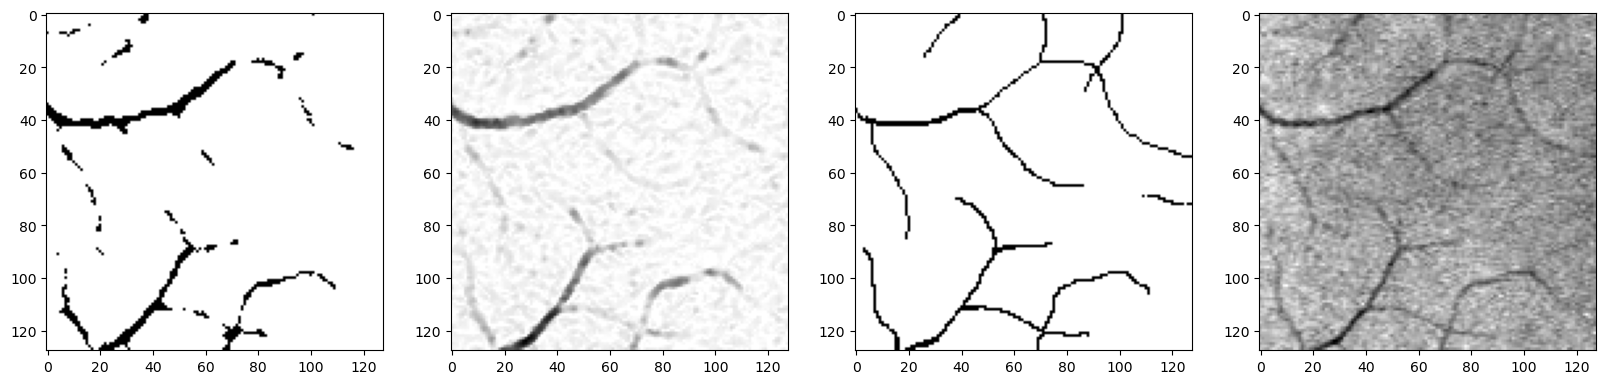

In [6]:
patch_size = 128
x, y = 240, 380

bin_res_patch = bin_res[x:x+patch_size, y:y+patch_size]
flux_patch = response[x:x+patch_size, y:y+patch_size]
label_patch = label[x:x+patch_size, y:y+patch_size]
image_patch = image[x:x+patch_size, y:y+patch_size]
rads_patch = rads[x:x+patch_size, y:y+patch_size]

_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(bin_res_patch, cmap='gray_r')
ax2.imshow(flux_patch, cmap='gray_r')
ax3.imshow(label_patch, cmap='gray_r')
ax4.imshow(image_patch, cmap='gray_r')

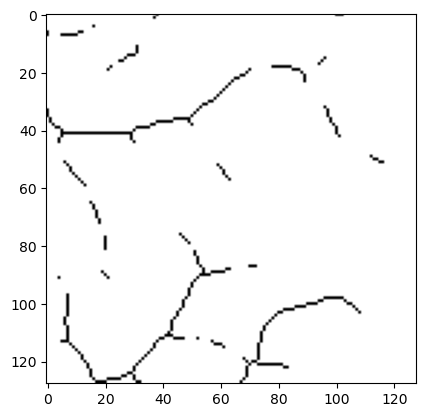

In [7]:
skel_patch = skeletonize(binary_dilation(bin_res_patch)) > 0.5
plt.imshow(skel_patch, cmap='gray_r')

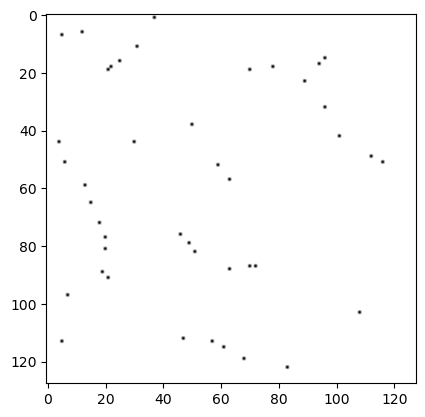

In [8]:
def line_ends(patch):
    return patch[4] == 1 and np.sum(patch) == 2

line_ends_im = generic_filter(skel_patch, line_ends, (3, 3))
locations = np.argwhere(line_ends_im > 0.5)
plt.imshow(line_ends_im, cmap='gray_r')

# Start Sampling the Curves

In [3]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from PTF import propagate_frame
from loss import get_sampling_vec

In [10]:
_flux_patch = torch.from_numpy(flux_patch).unsqueeze(0).unsqueeze(0)
_locations = torch.from_numpy(locations).unsqueeze(0)
_optimal_dir = F.normalize(torch.randn(locations.shape[0], 2).unsqueeze(0), dim=-1)
_estimated_rad = torch.ones(locations.shape[0], 128).unsqueeze(0) * 0.5
# line_ends_rads = rads_patch[locations[:, 0], locations[:, 1]]
# _estimated_rad = torch.from_numpy(line_ends_rads).repeat(128, 1).unsqueeze(0)
# _estimated_rad = _estimated_rad.permute(0, 2, 1) * 0.6
print(_estimated_rad.shape)

samplings = get_sampling_vec(32, dim=4)
print(samplings.shape)

torch.Size([1, 43, 128])
torch.Size([32, 2])


In [11]:
def get_rotation_matrix_3d(src_dir, des_dir):
    """
    Compute a matrix R that rotates v1 to align with v2
    :param src_dir: 3D image [B, N, 3]. Optimal direction
    :param des_dir: 3-dim 1d vector
    :return: rotation_matrices, 3 by 3 rotation matrix
    """
    b, n, c = src_dir.size()                                                # dimension of the vector
    src_dir = F.normalize(src_dir, dim=-1).view(-1, c)                      # normalize the vectors and flatten pixels
    des_dir = F.normalize(des_dir, dim=0)                                   # normalize the destination vectors
    des_dir = des_dir.repeat((src_dir.size(0), 1))                          # destination shape [N(b*k), 3]
    t = torch.bmm(src_dir.unsqueeze(2), des_dir.unsqueeze(1))               # [N, 3, 3]
    t -= torch.bmm(des_dir.unsqueeze(2), src_dir.unsqueeze(1))              # [N, 3, 3]
    rotation_matrices = torch.eye(c).repeat((src_dir.size(0), 1, 1))        # initialize the rotation matrix
    angle = torch.sum(src_dir * des_dir, dim=1)[:, None, None]              # the angle between the vectors [B,]
    rotation_matrices += t + torch.bmm(t, t) / (1 + angle)                  # construct the reconstruction matrix
    pos_indices = torch.argwhere(torch.abs(angle - 1.0) < 1.0e-10)          # find edge cases, same direction
    neg_indices = torch.argwhere(torch.abs(angle + 1.0) < 1.0e-10)          # find edge cases, opposite direction
    rotation_matrices[pos_indices] = torch.eye(c)                           # same direction,  identity
    rotation_matrices[neg_indices] = -torch.eye(c)                          # opposite direction, reverse identity
    rotation_matrices = rotation_matrices.view(b, n, c, c)                  # re-assemble the pixels
    return rotation_matrices

def get_local_frame(optimal_dir):
    """
    Compute the local frame based on the optimal dir
    :param optimal_dir: Optimal direction, 2D image [B, N, 2], 3D image [B, N, 3]
    :return: local frames, 2D image [B, N, 2, 2], 3D image [B, N, 3, 3]
    """
    if optimal_dir.shape[-1] == 3:
        x_axis = torch.tensor([1, 0, 0]) + 0.0
        y_axis = torch.tensor([0, 1, 0]) + 0.0
        z_axis = torch.tensor([0, 0, 1]) + 0.0
        rt_mtx = get_rotation_matrix_3d(optimal_dir, z_axis)
        new_x_axis = torch.matmul(rt_mtx, x_axis)
        new_y_axis = torch.matmul(rt_mtx, y_axis)
        frame = torch.stack((new_x_axis, new_y_axis, optimal_dir), dim=-1)
    else:
        index = torch.LongTensor([1, 0]).to(optimal_dir.device)
        ort_dir1 = torch.index_select(optimal_dir, -1, index)               # [B, N, 2]
        ort_dir1[:, :, 1] = - ort_dir1[:, :, 1]                             # [B, N, 2]
        ort_dir1 = F.normalize(ort_dir1, dim=-1) + 1e-10                    # [B, K, 2]
        frame = torch.stack((optimal_dir, ort_dir1), dim=3)                 # [B, N, 2, 2]
    return frame

def model_tube(flux, init_frame, mean_rad, probe_num, sample_pt_num, step_len, k1, k2=None):
    """
    Model the tube structure of the vessel
    :param flux: 2D image [B, 1, H, W], 3D image [B, 1, H, W, D]. Vesselness response
    :param init_frame: initial image frame, [B, N, 3, 2], [B, N, 4, 3], in image space
    :param mean_rad: scalar field of mean radius, [B, H, W, 1], [B, H, W, D, 1]
    :param probe_num: number of probing
    :param sample_pt_num: number of sampling on the cross-sectional plane
    :param step_len: step length of each probe, in pixels
    :param k1: first curvature, [B, N, 1], [B, N, 1]
    :param k2: second curvature, [B, N，1]
    :return: response_prior
    """
    device = flux.device
    b, c, h, w = flux.shape[:4]
    n = k1.shape[1]
    k1 = k1.squeeze(-1)                                                     # [B, N], [B, N]
    k2 = k2.squeeze(-1) if k2 is not None else None                         # [B, N]
    step_len = step_len if isinstance(step_len, float) else step_len.squeeze(-1)
    indices = torch.LongTensor([2, 1, 0]) if init_frame.shape[-1] == 3 else torch.LongTensor([1, 0])
    indices = indices.to(device)
    response_prior = torch.zeros((b, c, 1, n), device=device)            # initialize the accumulated vesselness
    curr_frame = init_frame                                                 # initial image frame, normalized
    final_path = []
    for _ in range(probe_num):
        xt = torch.select(curr_frame, dim=-2, index=0)                      # image coordinates in image space
        Tt = torch.select(curr_frame, dim=-2, index=1)                      # normalized vessel direction
        K1 = torch.select(curr_frame, dim=-2, index=2)                      # normalized k1 direction
        K2 = torch.select(curr_frame, dim=-2, index=3) if curr_frame.dim() == 6 else None
        final_path.append(xt)
        for i in torch.linspace(-1.0, 1.0, sample_pt_num):
            sample_pt_num_2 = sample_pt_num if K2 is not None else 1
            for j in torch.linspace(-1.0, 1.0, sample_pt_num_2):
                if K2 is not None:
                    sample_dir = F.normalize(K1 * i + K2 * j, dim=-1)       # [B, N, 2], [B, N, 3]
                else:
                    sample_dir = F.normalize(K1 * i, dim=-1)                # [B, N, 2], [B, N, 3]
                sample_pos = xt + sample_dir * mean_rad                     # sample position over the image
                sample_pos = torch.index_select(sample_pos, -1, indices)    # swap the x and z axis
                sample_pos[..., 0] = 2.0 * sample_pos[..., 0] / h - 1
                sample_pos[..., 1] = 2.0 * sample_pos[..., 1] / w - 1
                sample_pos = sample_pos.unsqueeze(dim=1).double()
                curr_response = F.grid_sample(flux, sample_pos, align_corners=True)
                response_prior += curr_response / sample_pt_num / sample_pt_num_2 / probe_num
        curr_frame = propagate_frame(curr_frame, step_len, k1, k2)          # propagate the image frame
    response_prior = response_prior.view(b, -1)
    final_path = torch.stack(final_path, dim=-2)
    return response_prior, final_path

In [13]:
def sample_curve(flux_res, optimal_dir, estimated_rad, end_locs, sample_num, prob_num=10, pt_num=5, step_len=0.5):
    """
    Sample the curves over the whole images
    :param flux_res: 2D image [B, 1, H, W], 3D image [B, 1, H, W, D]. Vesselness response
    :param optimal_dir: 2D image [B, K, 2], 3D image [B, K, 3]. Optimal direction
    :param estimated_rad: 2D image [B, H, W, R], 3D image [B, H, W, D, R]. Estimated radius
    :param end_locs: line-ends locations, [B, N, 2], [B, N, 3]
    :param sample_num: number of curves to probe
    :param prob_num: number of probing of vessels
    :param pt_num: number of sampling on the cross-sectional plane
    :param step_len: step length of each probe, in pixels
    :return:
    """
    b, n, ndim = end_locs.shape
    device, dim = flux_res.device, flux_res.dim()                           # dimension of response, 2d or 3d
    mean_rad = torch.mean(estimated_rad, dim=-1, keepdim=True)              # mean radius, [B, H, W, 1], [B, H, W, D, 1]
    min_rad, _ = torch.min(estimated_rad, dim=-1, keepdim=True)             # min radius, [B, H, W, 1], [B, H, W, D, 1]
    # print(min_rad.size())
    optimal_prior = torch.zeros((b, n), device=device)                      # [B, H, W, 1], [B, H, W, D, 1]
    optimal_k1 = torch.zeros((b, n), device=device)                # [B, H, W, 1], [B, H, W, D, 1]
    optimal_k2 = torch.zeros((b, n), device=device) if dim == 5 else None      # [B, H, W, D, 1]
    # repeat_size = (1, 1, 1, 1, 6 * prob_num) if dim == 5 else (1, 1, 1, 4 * prob_num)
    optimal_path = torch.zeros((b, n, 2, prob_num, ndim), device=device)     # [B, H, W, prob_num * 2]
    ranges = torch.linspace(-0.035, 0.035, sample_num)
    for j in tqdm(range(samplings.shape[0])):
        optimal_dir = samplings[j].repeat((b, n, 1))
        frame = get_local_frame(optimal_dir)                                    # local frame of every
        init_frame = torch.cat((end_locs.unsqueeze(-2), frame), dim=-2)         # [B, K, 3, 2], [B, K, 4, 3]
        init_frame_r = torch.cat((end_locs.unsqueeze(-2), -frame), dim=-2)      # reversed frame
        
        for i in range(sample_num):
            k1 = torch.ones(mean_rad.size(), device=device) * ranges[i] / mean_rad / 2.0
            k2 = torch.ones(mean_rad.size(), device=device) * ranges[i] / mean_rad / 2.0 if dim == 5 else None
            # model the tube and calculate prior
            prior_1, final_path_1 = model_tube(flux_res, init_frame, mean_rad, prob_num, pt_num, min_rad * step_len, k1, k2)
            prior_2, final_path_2 = model_tube(flux_res, init_frame_r, mean_rad, prob_num, pt_num, min_rad * step_len, -k1, k2)
            response_prior = prior_1 + prior_2
            # update the optimal curvatures based on the priors
            optimal_k1 = torch.where(response_prior > optimal_prior, k1, optimal_k1)
            if k2 is not None:
                optimal_k2 = torch.where(response_prior > optimal_prior, k2, optimal_k2)
            # update the optimal path
            # temp_prior, temp_optimal_prior = response_prior.repeat(repeat_size), optimal_prior.repeat(repeat_size)
            final_path = torch.stack((final_path_1, final_path_2), dim=-3)
            threshes = torch.ones_like(optimal_prior) * 0.005
            optimal_indices = torch.where(response_prior > torch.maximum(optimal_prior, threshes))
            optimal_indices = torch.stack(optimal_indices, dim=-1)
            if len(optimal_indices) > 0:
                # update the optimal path
                optimal_path[optimal_indices[:, 0], optimal_indices[:, 1]] = final_path[optimal_indices[:, 0], optimal_indices[:, 1]]
                # update the optimal priors
                optimal_prior[optimal_indices[:, 0], optimal_indices[:, 1]] = response_prior[optimal_indices[:, 0], optimal_indices[:, 1]]
    optimal_res = {
        'prior': optimal_prior,
        'k1': optimal_k1,
        'k2': optimal_k2,
        'path': optimal_path
    }
    return optimal_res

res = sample_curve(_flux_patch, _optimal_dir, _estimated_rad, _locations, sample_num=32, prob_num=60)    
print(res['path'].shape)

100%|██████████| 32/32 [00:37<00:00,  1.16s/it]

torch.Size([1, 43, 2, 60, 2])


tensor(0.0131)


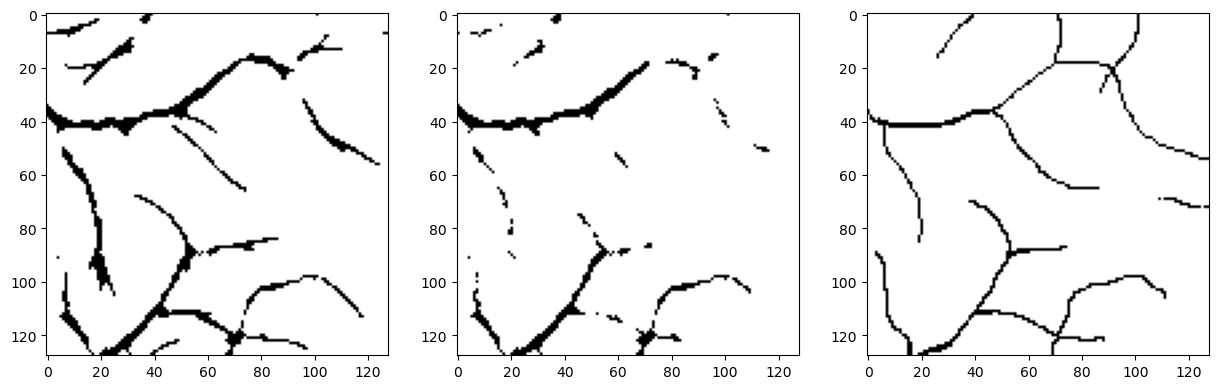

In [14]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))

new_bin_res_patch = bin_res_patch.copy()

for i in range(res['path'].shape[1]):
    curr_path1 = res['path'][0, i, 0]
    curr_path2 = res['path'][0, i, 1]
    curr_path1 = np.minimum(curr_path1, 127.0)
    curr_path2 = np.minimum(curr_path2, 127.0)
    # ax1.plot(curr_path1[:, 1], curr_path1[:, 0], color='red', linewidth=1.0)
    new_bin_res_patch[curr_path1[:, 0].int(), curr_path1[:, 1].int()] = 1.0
    # new_bin_res_patch[curr_path2[:, 0].int(), curr_path2[:, 1].int()] = 1.0
    # plt.plot(curr_path2[:, 1], curr_path2[:, 0], color='black')
    
ax1.imshow(binary_closing(new_bin_res_patch), cmap='gray_r')
ax2.imshow(bin_res_patch, cmap='gray_r')
ax3.imshow(label_patch, cmap='gray_r')
print(res['prior'].mean())

In [ ]:
plt.imshow(label_patch, cmap='gray_r')

In [14]:
from torchvision.transforms.functional import crop


img = torch.randn(1, 128, 128, 128)
cropped = crop(img, 12, 12, 64, 64)
cropped.shape

torch.Size([1, 128, 64, 64])

In [16]:
import time

start = time.time()
features = torch.randn(4, 1, 128, 128)
indices = torch.randn(4, 1, 30, 2)
s = F.grid_sample(features, indices, align_corners=True)
end = time.time()
end-start

0.0011179447174072266

In [20]:
start = time.time()
features = torch.randn(160, 1, 32, 32)
indices = torch.randn(160, 1, 1, 2)
s = F.grid_sample(features, indices, align_corners=True)
end = time.time()
end-start

0.0018203258514404297